In [1]:
!rm -rf IFIC-SummerSchool-2025
!git clone https://github.com/M0V1/IFIC-SummerSchool-2025.git
!pip install  numpy pandas uproot matplotlib mplhep awkward

Cloning into 'IFIC-SummerSchool-2025'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 89 (delta 38), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 74.95 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (20/20), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.8/382.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.5 MB/s eta 0:00:00


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from concurrent.futures import ProcessPoolExecutor, as_completed
import time

# Integrated luminosity in inverse picobarns
lumi = 36000.

In [68]:
files = [
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root",   #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_410471.PhPy8EG_A14_ttbar_hdamp258p75_allhad.2J2LMET30.root",     #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345121.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulm15hp20.2J2LMET30.root", #signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345122.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulp15hm20.2J2LMET30.root",#signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346343.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_allhad.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700792.Sh_2214_Ztautau_maxHTpTV2_BFilter.2J2LMET30.root",     #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodF.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346344.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_semilep.2J2LMET30.root", #signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodH.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700902.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CFilterBVeto.2J2LMET30.root", #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345120.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaul13l7.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700901.Sh_2214_Ztt_maxHTpTV2_Mll10_40_BFilter.2J2LMET30.root" #bkg
]
import os

files_data=["/content/drive/MyDrive/Colab Notebooks/data15_periodD.2bjets70.root"]
tree_name = "analysis"

In [69]:
def calc_weight(data):
    weight_list = ( data["ScaleFactor_PILEUP"] *
                   (data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) *
                   (data["xsec"] * data["filteff"] * data["kfac"] * lumi))
    return weight_list

In [70]:
def Hmass(E, pt, eta, phi):
    jet_E = ak.sum(E, axis=1)
    jet_px = ak.sum(pt * np.cos(phi), axis=1)
    jet_py = ak.sum(pt * np.sin(phi), axis=1)
    jet_pz = ak.sum(pt * np.tanh(eta), axis=1)
    Mass = np.sqrt(jet_E**2 - (jet_px**2 + jet_py**2 + jet_pz**2))
    return Mass

In [71]:
def process_file(file_path, tree_name, loop):
    tree = uproot.open(f"{file_path}:{tree_name}")
    sample_data = []

    variables = [ "met", "lep_type", "lep_isMediumID", "lep_isLooseIso", "jet_e", "jet_pt", "jet_eta", "jet_phi", "jet_btag_quantile",  "ScaleFactor_PILEUP", "ScaleFactor_BTAG", "mcWeight", "sum_of_weights", "xsec", "filteff", "kfac"]

    for data in tree.iterate(variables, library="ak", entry_start=int(tree.num_entries * fraction * loop), entry_stop=int(tree.num_entries * fraction * (loop + 1))):

        data['Inv_mass'] = Hmass(data.jet_e, data.jet_pt, data.jet_eta, data.jet_phi)
        data['Weight'] = calc_weight(data)
        sample_data.append(data)

    return ak.concatenate(sample_data, axis=0)

In [72]:
def parallel_analysis(file_list, tree_name):
    combined_data = []
    for file_path in file_list:
        with ProcessPoolExecutor() as executor:
            futures = {executor.submit(process_file, file_path, tree_name, i): i for i in range(10)}
            results = []
            for future in as_completed(futures):
                try:
                    results.append(future.result())
                except Exception as e:
                    print(f"Error in file {file_path}, loop {futures[future]}: {e}")
        if results:
            combined_data.append(ak.concatenate(results, axis=0))

    return ak.concatenate(combined_data, axis=0) if combined_data else ak.Array([])

In [73]:
# Main analysis loop
start_all = time.time()
fraction = 1
print("The analysis has started")

bkg_files = [
    files[0],  # Ztt_maxHTpTV2_Mll10_40_CVetoBVeto
    files[1],  # ttbar_allhad
    files[5],  # Ztautau_maxHTpTV2_BFilter
    files[9], # Ztt_maxHTpTV2_CFilterBVeto
    files[11]  # Ztt_maxHTpTV2_BFilter
]

signal_files = [
    files[2],  # ggH125_tautaulm15hp20
    files[3],  # ggH125_tautaulp15hm20
    files[10], # ggH125_tautaul13l7
    files[4],  # ttH125_allhad
    files[7],  # ttH125_semilep
]

data_files = [
    files_data[0]
    #files[6],  # data15_periodF
    #files[8],  # data15_periodD
    #files[9],  # data15_periodH
]

bkg_data = parallel_analysis(bkg_files, tree_name)
signal_data = parallel_analysis(signal_files, tree_name)
data_data = parallel_analysis(data_files, tree_name)

The analysis has started
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 1: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 2: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 3: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 4: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 5: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-202

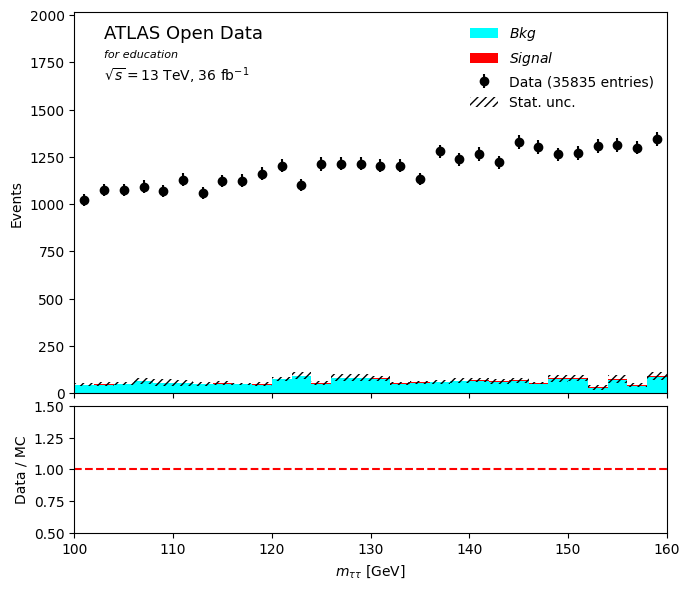

In [74]:
def plot_data(bkg, signal, data, fit=True):
    xmin, xmax, step_size = 100, 160, 2
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2


    data_y, _ = np.histogram(data['Inv_mass'], bins=bin_edges)
    data_yerr = np.sqrt(data_y)


    bkg_y, _ = np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight'])
    signal_y, _ = np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight'])


    stacked_mc = np.vstack([bkg_y, signal_y])
    total_mc = np.sum(stacked_mc, axis=0)


    total_mc_err = np.sqrt(
        np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0] +
        np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight']**2)[0]
    )

    fig, (main_ax, ratio_ax) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    main_ax.errorbar(bin_centres, data_y, yerr=data_yerr, fmt='ko', label=f'Data ({sum(data_y)} entries)')


    main_ax.hist([bkg['Inv_mass'], signal['Inv_mass']],
                 bins=bin_edges,
                 weights=[bkg['Weight'], signal['Weight']],
                 stacked=True,
                 color=['cyan', 'red'],
                 label=[r'$Bkg$', r'$Signal$'])


    main_ax.bar(bin_centres, 2 * total_mc_err, alpha=0.5, bottom=total_mc - total_mc_err,
                color='none', hatch="////", width=step_size, label='Stat. unc.')

    main_ax.set_xlim(xmin, xmax)
    main_ax.set_ylim(0, max(max(data_y), max(total_mc)) * 1.5)
    main_ax.set_ylabel("Events")
    main_ax.text(0.05, 0.93, 'ATLAS Open Data', transform=main_ax.transAxes, fontsize=13)
    main_ax.text(0.05, 0.88, 'for education', transform=main_ax.transAxes, style='italic', fontsize=8)
    main_ax.text(0.05, 0.82, r'$\sqrt{s}=13$ TeV, 36 fb$^{-1}$', transform=main_ax.transAxes)
    main_ax.legend(frameon=False)


    ratio = data_y / total_mc
    ratio_err = ratio * np.sqrt((data_yerr / data_y)**2 + (total_mc_err / total_mc)**2)
    ratio_ax.errorbar(bin_centres, ratio, yerr=ratio_err, fmt='ko')
    ratio_ax.axhline(1, color='red', linestyle='--')
    ratio_ax.set_ylabel("Data / MC")
    ratio_ax.set_ylim(0.5, 1.5)
    ratio_ax.set_xlabel(r"$m_{\tau\tau}$ [GeV]")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.show()


plot_data(bkg_data, signal_data, data_data)